In [29]:
import importlib
import os
import sys

import numpy as np
import pandas as pd
from datasets import Dataset
sys.path.append("../")

import src

importlib.reload(src)

from src.data_prep_utils import (  # noqa: E402
    conala_to_time_batches,
    load_time_sorted_conala,
)

importlib.reload(src.data_prep_utils)


from src.training import nd_inference, retraining, continual
importlib.reload(src.training)

import torch
from transformers import (
    DataCollatorForSeq2Seq,
    RobertaTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    T5ForConditionalGeneration,
)
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from src.processing_utils import compute_metric_with_params, prepare_hg_ds
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import evaluate

In [30]:
#%pip install rouge_score
#%pip install absl
#%pip install seaborn
#%pip install transformers[torch]

In [31]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [40]:
MODEL = "CodeT5"
TRAIN_N = 330
BATCH_SIZE = 15
DECODER_LENGTH = 20
ENCODER_LENGTH = 15

TRAIN_ARGS = {
    "TRAIN_N": TRAIN_N,
    "BATCH_SIZE": BATCH_SIZE,
    "DECODER_LENGTH": DECODER_LENGTH,
    "ENCODER_LENGTH": ENCODER_LENGTH,
    "MODEL": MODEL,
    "SEQ_TRAINER_ARGS": {
        "overwrite_output_dir": True,
        "num_train_epochs": 10,
        "do_train": True,
        "do_eval": True,
        "per_device_train_batch_size": 4,
        "per_device_eval_batch_size": 4,
        "learning_rate": 5e-4,
        "warmup_steps": 100,
        "weight_decay": 0.1,
        "label_smoothing_factor": 0.1,
        "predict_with_generate": True,
        "logging_steps": 100,
        "save_total_limit": 1,
        "save_strategy": "no",
        "logging_strategy": "epoch",
        "evaluation_strategy": "epoch",
        "load_best_model_at_end": False,
    },
}

In [33]:
#df = load_time_sorted_conala("../data/raw/conala")  # noqa: PD901
#df = conala_to_time_batches(df, 30, BATCH_SIZE)  # noqa: PD901
DATE_STR = "20240327"
df = pd.read_csv(f"../data/processed/conala/{DATE_STR}/all_drifts.csv")
df["t_batch"] = df["time_batch"]

model_name="Salesforce/codet5-base-multi-sum"
tokenizer = AutoTokenizer.from_pretrained(model_name, skip_special_tokens=False)

KeyboardInterrupt: 

In [ ]:
df.loc[df.rewritten_intent.isna(), "rewritten_intent"] = "translate an ISO 8601 datetime string into a Python datetime object"

In [ ]:
def prep_for_hf(df: pd.DataFrame, batch_id: int|list, batch_name: str) -> Dataset:
    """Convert pandas dataframe to huggingface."""
    df = df.rename(columns={"snippet": "input_sequence",  # noqa: PD901
                    "rewritten_intent" : "output_sequence"})
    if batch_id == -999: 
        df = df.loc[:, ["input_sequence", "output_sequence", "idx"]]  # noqa: PD901
    elif isinstance(batch_id, list):
        df = df.loc[df[batch_name].isin(batch_id), ["input_sequence", "output_sequence", "idx"]]  # noqa: PD901
    elif isinstance(batch_id, int):
        df = df.loc[df[batch_name]==batch_id, ["input_sequence", "output_sequence", "idx"]]  # noqa: PD901
    df = df.sample(frac=1, random_state=42)  # noqa: PD901
    return Dataset.from_pandas(df)

In [ ]:
def batch_tokenize_preprocess(batch, tokenizer, max_input_length, max_output_length):

    source = batch["input_sequence"]
    target = batch["output_sequence"]

    source_tokenized = tokenizer(
        source, padding="max_length",
        truncation=True, max_length=max_input_length
    )

    target_tokenized = tokenizer(
        target, padding="max_length",
        truncation=True, max_length=max_output_length
    )

    batch = {k: v for k, v in source_tokenized.items()}

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label]
        for label in target_tokenized["input_ids"]
    ]

    return batch

In [ ]:
train_idx = sorted(df.question_id.unique())[:1501]
test_idx = sorted(df.question_id.unique())[1501:]

In [ ]:
COLUMN_BATCH = "time_batch"

train_df = df.loc[df.question_id.isin(train_idx),:]
test_df = df.loc[df.question_id.isin(test_idx),:]

train_dataset = prep_for_hf(train_df, -999, COLUMN_BATCH)

train_data = train_dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch,
            tokenizer=tokenizer,
            max_input_length=15,
            max_output_length=20,
        ),
        batch_size=4,
        batched=True,
        #remove_columns=train_dataset.column_names,
    )

test_dataset = prep_for_hf(test_df, -999, COLUMN_BATCH)

test_data = test_dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch,
            tokenizer=tokenizer,
            max_input_length=15,
            max_output_length=20,
        ),
        batch_size=4,
        batched=True,
        #remove_columns=train_dataset.column_names,
    )

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

print(device)
model.to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

compute_metrics = compute_metric_with_params(tokenizer)

cuda


In [41]:
TRAIN_ARGS["SEQ_TRAINER_ARGS"]["output_dir"] = f'reports/upper_bound/results'
TRAIN_ARGS["SEQ_TRAINER_ARGS"]["logging_dir"] = f'reports/upper_bound/logs'

if not os.path.exists(f'reports/{COLUMN_BATCH}'): 
    os.mkdir(f'reports/{COLUMN_BATCH}')

training_args = Seq2SeqTrainingArguments(
        **TRAIN_ARGS["SEQ_TRAINER_ARGS"],
    )


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/RDC/zinovyee.hub/.conda/envs/dd_spek/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [42]:
MODEL_PATH = f"reports/upper_bound/saved_model"
if not os.path.exists(MODEL_PATH): 
    os.mkdir(MODEL_PATH)

In [43]:
trainer.train()
trainer.save_model(MODEL_PATH)

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len,Bleu,Brevity Penalty,Length Ratio,Translation Length,Reference Length
1,2.278800,4.137460,0.336800,0.112600,0.298200,0.298100,15.448400,0.123400,0.954900,0.955900,9074,9493
2,2.254200,4.139294,0.349800,0.116500,0.306300,0.306000,14.947000,0.125300,0.863200,0.871800,8276,9493
3,2.172300,4.068083,0.365000,0.127900,0.321700,0.321700,15.434100,0.135700,0.931800,0.934100,8867,9493
4,1.998700,4.126929,0.374700,0.134100,0.330800,0.331100,15.021500,0.132800,0.894900,0.900000,8544,9493
5,1.813500,4.221631,0.379700,0.133100,0.331600,0.331700,15.285100,0.140600,0.913700,0.917200,8707,9493
6,1.688700,4.235121,0.376400,0.130900,0.326600,0.326900,15.977100,0.140300,0.975500,0.975800,9263,9493
7,1.597400,4.276055,0.371300,0.127400,0.324000,0.324100,15.567300,0.135500,0.938000,0.939900,8922,9493
8,1.520300,4.235991,0.384700,0.136300,0.335100,0.335000,16.068800,0.142800,0.968700,0.969100,9200,9493
9,1.471900,4.272577,0.385600,0.141200,0.335900,0.335900,15.759300,0.149800,0.954400,0.955400,9070,9493
10,1.443500,4.275604,0.392900,0.145700,0.342000,0.341900,15.796600,0.151000,0.952600,0.953700,9053,9493


/home/RDC/zinovyee.hub/.conda/envs/dd_spek/lib/python3.11/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


In [44]:
def generate_summary(test_samples, model, tokenizer, encoder_max_length, decoder_max_length):

    inputs = tokenizer(
        test_samples["input_sequence"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=decoder_max_length)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str

In [52]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, skip_special_tokens=False)

In [58]:
text = test_df.snippet.values
summaries = generate_summary(test_data, model, tokenizer, 50, 50)

test_df[f"{COLUMN_BATCH}_prediction_nd"] = "USED IN TRAIN"
test_df.loc[:, f"{COLUMN_BATCH}_prediction_nd"] = summaries[1]

/tmp/ipykernel_156947/711909006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"{COLUMN_BATCH}_prediction_nd"] = "USED IN TRAIN"


In [60]:
summaries

(tensor([[   0,    1, 1356,  ...,    0,    0,    0],
         [   0,    1, 3125,  ...,    0,    0,    0],
         [   0,    1,  967,  ...,    0,    0,    0],
         ...,
         [   0,    1, 3495,  ...,    0,    0,    0],
         [   0,    1, 1356,  ...,    0,    0,    0],
         [   0,    1, 3043,  ...,    0,    0,    0]]),
 ['Returns a DataFrame with the difference between the values of df and df2.',
  'Find all spaces in s.',
  'Get the basename of the file',
  'Commit the transaction',
  'Get the keyword from the page',
  'pd = x x + 5',
  'get all keys',
  'Find all CONCERTATION elements.',
  'All balls are considered balls.',
  'Returns the host of the request.',
  'Returns the concatenation of the first word and the rest of the word.',
  'This is a hack to avoid the use of the default values of the dictionary.',
  'Get username from request',
  'Append a new item to the end of the list.',
  'Save the figure to a png file.',
  'Find all the words in file. txt that are not 

In [55]:
rouge = evaluate.load('rouge')

test_df[f"{COLUMN_BATCH}_prediction_nd_rouge"] = -999
test_df[f"{COLUMN_BATCH}_prediction_nd_rouge"] = test_df.progress_apply(lambda x: rouge.compute(predictions=[x[f"{COLUMN_BATCH}_prediction_nd"]], references=[x["rewritten_intent"]])["rouge1"], axis=1)


/tmp/ipykernel_156947/1491341020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f"{COLUMN_BATCH}_prediction_nd_rouge"] = -999
  0%|          | 2/698 [00:00<01:06, 10.48it/s]INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
 38%|███▊      | 268/698 [00:31<00:46,  9.30it/s]INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
 50%|█████     | 352/698 [00:40<00:41,  8.38it/s]INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
 51%|█████     | 354/698 [00:41<00:38,  8.99it/s]INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
 51%|█████     | 357/698 [00:41<00:36,  9.39it/s]INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
 54%|█████▎    | 375/698

In [56]:
test_df

,question_id,intent,rewritten_intent,snippet,idx,time_batch,cluster,gradual_batch,gradual_new,recurring_batch,rec_new,sudden_batch,sudden_new,t_batch,time_batch_prediction_nd_rouge,time_batch_prediction_nd
2181,19112735,Python - print tuple elements with no brackets,print each first value from a list of tuples `...,"print(', ,'.join([str(i[0]) for i in mytuple]))",2181,47,7,43,1,0,0,0,0,47,0.173913,Returns a DataFrame with the difference betwee...
2182,19121722,Build Dictionary in Python Loop - List and Dic...,build dictionary with keys of dictionary `_con...,{_key: _value(_key) for _key in _container},2182,47,1,28,0,21,0,26,0,47,0.000000,Find all spaces in the string
2183,19153328,How to dynamically assign values to class prop...,assign value in `group` dynamically to class p...,"setattr(self, attr, group)",2183,47,4,42,1,28,1,16,0,47,0.000000,Returns the basename of the current working di...
2184,19156472,Sorting numpy array on multiple columns in Python,Sort a structured numpy array 'df' on multiple...,"df.sort(['year', 'month', 'day'])",2184,47,3,6,0,60,0,51,0,47,0.000000,Commit the transaction
2185,19156472,Sorting numpy array on multiple columns in Python,sort array `order_array` based on column 'year...,"order_array.sort(order=['year', 'month', 'day'])",2185,47,6,62,0,36,0,36,0,47,0.000000,Find the first k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,42462530,How to replace the white space in a string in ...,replace white spaces in dataframe `df` with '_',"df.replace(' ', '_', regex=True)",2874,64,3,63,0,58,0,44,0,64,0.000000,Reset the index of the columns.
2875,42548362,Python. Convert escaped utf string to utf-string,Convert escaped utf string to utf string in `y...,print('your string'.decode('string_escape')),2875,65,8,0,0,62,0,40,0,65,0.000000,df. name. str. replace ( \ \
2876,42731970,Regex add character to matched string,replace periods `.` that are not followed by p...,"re.sub('\\.(?=[^ .])', '. ', para)",2876,65,8,1,0,63,0,43,0,65,0.000000,Sums the elements of the list.
2877,42747987,In pandas Dataframe with multiindex how can I ...,select the first row grouped per level 0 of da...,"df.groupby(level=0, as_index=False).nth(0)",2877,65,3,12,0,23,0,63,0,65,0.160000,A simple implementation of the NIST algorithm ...


In [57]:
ind_av_rouge_nd

NameError: name 'ind_av_rouge_nd' is not defined

In [ ]:
batch_rouge_calculations_nd

array([0.03149118, 0.04651758, 0.07287669, 0.04716621, 0.0519755 ,
       0.02584267, 0.06639654, 0.05126813, 0.0491036 , 0.04776335,
       0.0847129 , 0.14509066, 0.11961772, 0.11433795, 0.09788549,
       0.08458418, 0.10039315, 0.11850517, 0.11070642, 0.10062374,
       0.13542408, 0.11307251, 0.11466024, 0.1260714 , 0.11949531,
       0.0969807 , 0.09052475, 0.10523089, 0.10072654, 0.10306277,
       0.09894412, 0.10884068, 0.08842339, 0.1369818 , 0.11039604,
       0.10530818, 0.10424138, 0.12336962, 0.14119042, 0.07414483,
       0.0906845 , 0.08370405, 0.11296782, 0.11281154, 0.0898515 ,
       0.08680035, 0.08328066, 0.13322486, 0.0864336 , 0.09677599,
       0.14937711, 0.08139542, 0.14037723, 0.11407942, 0.09932757,
       0.10916047, 0.13302146, 0.09896987, 0.11447197, 0.12235826,
       0.13064426, 0.09512377, 0.09207974, 0.12583148, 0.08798246])

In [ ]:
len(range(11,66))

55

In [ ]:
df

,question_id,intent,rewritten_intent,snippet,idx,time_batch,cluster,gradual_batch,gradual_new,recurring_batch,rec_new,sudden_batch,sudden_new,t_batch,time_batch_prediction_nd,time_batch_prediction_nd_rouge
0,1476,express binary literals,convert binary string '11111111' to integer,"int('11111111', 2)",0,0,5,53,0,53,0,53,0,0,USED IN TRAIN,NaN
1,1476,express binary literals,convert 21 to binary string,bin(21),1,0,5,55,0,55,0,55,0,0,USED IN TRAIN,NaN
2,1476,express binary literals,convert binary string '0b0010101010' to integer,"int('0b0010101010', 2)",2,0,5,49,0,49,0,49,0,0,USED IN TRAIN,NaN
3,1476,express binary literals,convert binary string '010101' to integer,"int('010101', 2)",3,0,5,50,0,50,0,50,0,0,USED IN TRAIN,NaN
4,1476,express binary literals,convert binary string '01010101111' to integer,"int('01010101111', 2)",4,0,5,51,0,51,0,51,0,0,USED IN TRAIN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,42462530,How to replace the white space in a string in ...,replace white spaces in dataframe `df` with '_',"df.replace(' ', '_', regex=True)",2874,64,3,63,0,58,0,44,0,64,download a file `url` over HTTP,0.000000
2875,42548362,Python. Convert escaped utf string to utf-string,Convert escaped utf string to utf string in `y...,print('your string'.decode('string_escape')),2875,65,8,0,0,62,0,40,0,65,"compare two lists in python `[1, 2, 3]` and `[",0.105263
2876,42731970,Regex add character to matched string,replace periods `.` that are not followed by p...,"re.sub('\\.(?=[^ .])', '. ', para)",2876,65,8,1,0,63,0,43,0,65,remove parentheses and text within it in strin...,0.080000
2877,42747987,In pandas Dataframe with multiindex how can I ...,select the first row grouped per level 0 of da...,"df.groupby(level=0, as_index=False).nth(0)",2877,65,3,12,0,23,0,63,0,65,limit float 135578.46 to two decimal points,0.000000


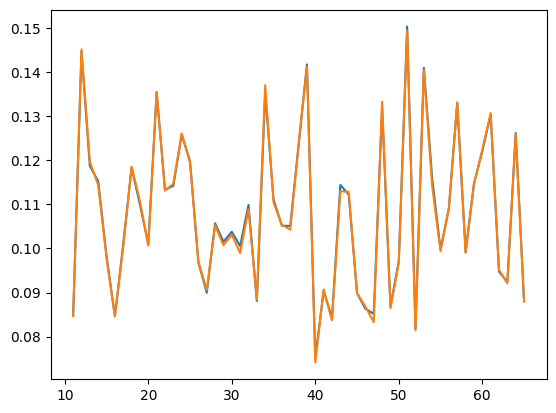

In [ ]:
import matplotlib.pyplot as plt
sns.lineplot(x=range(11,66), y=ind_av_rouge_nd[10:])
sns.lineplot(x=range(11, 66), y=batch_rouge_calculations_nd[10:])
plt.savefig(f'reports/{COLUMN_BATCH}/nd_infer/output.png')

In [ ]:
# SAVE RESULTS
import pickle
df.to_csv(f'reports/{COLUMN_BATCH}/nd_infer/results.csv')

with open(f'reports/{COLUMN_BATCH}/nd_infer/ind_av_rouge_nd.pickle', 'wb') as handle:
    pickle.dump(ind_av_rouge_nd, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'reports/{COLUMN_BATCH}/nd_infer/batch_rouge_calculations_nd.pickle', 'wb') as handle:
    pickle.dump(batch_rouge_calculations_nd, handle, protocol=pickle.HIGHEST_PROTOCOL)